# Анализ защищенности систем искусственного интеллекта

### Группа: ББМО-02-23
### Студент: Васильев Григорий Максимович
### Вариант: 3


**Получаем копию репозитория EEL6812_DeepFool_Project на нашем локальном устройстве**

In [ ]:
!git clone https://github.com/ewatson2/EEL6812_DeepFool_Project

Cloning into 'EEL6812_DeepFool_Project'...
remote: Enumerating objects: 96, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 96 (delta 2), reused 1 (delta 1), pack-reused 93 (from 1)
Receiving objects: 100% (96/96), 33.99 MiB | 16.41 MiB/s, done.
Resolving deltas: 100% (27/27), done.


**Переходим в директорию EEL6812_DeepFool_Project, созданную ранее с помощью команды git clone**

In [ ]:
%cd EEL6812_DeepFool_Project/

/content/EEL6812_DeepFool_Project


**Импорт библиотек**

* warnings: Модуль для управления предупреждениями, позволяющий игнорировать или фильтровать их.
* numpy: Библиотека для работы с многомерными массивами и выполнением численных операций.
* json: Модуль для работы с данными в формате JSON, включая их парсинг и сериализацию.
* torch: Основная библиотека для создания и обучения нейронных сетей с использованием PyTorch.
* torch.utils.data: Модуль, предоставляющий инструменты для загрузки и обработки данных, включая DataLoader и random_split.
* torchvision: Библиотека для работы с изображениями, предоставляющая набор инструментов для обработки и трансформации изображений.
* torchvision.transforms: Модуль для применения различных преобразований к изображениям, таких как нормализация и аугментация.

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import json, torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, models
from torchvision.transforms import transforms

**Импортируем пользовательские модели и утилиты из соответствующих модулей проекта.**

Из models.project_models загружаются архитектуры нейронных сетей, такие как FC_500_150, LeNet_CIFAR, LeNet_MNIST и Net, а из utils.project_utils — функции get_clip_bounds, evaluate_attack и display_attack, необходимые для обработки данных, оценки атак на модели и визуализации результатов.

In [ ]:
from models.project_models import FC_500_150, LeNet_CIFAR, LeNet_MNIST, Net
from utils.project_utils import get_clip_bounds, evaluate_attack, display_attack

In [ ]:
rand_seed = 3 # мой номер

**устанавливаются семена случайных чисел для двух библиотек: numpy и torch**

* np.random.seed(rand_seed): Эта команда фиксирует генерацию случайных чисел в библиотеке NumPy, чтобы гарантировать воспроизводимость результатов при повторных запусках кода.
* torch.manual_seed(rand_seed): Устанавливает тот же самый семя для генератора случайных чисел в PyTorch, что также помогает обеспечить стабильность и воспроизводимость экспериментов, особенно при работе с нейронными сетями.

In [ ]:
np.random.seed(rand_seed)
torch.manual_seed(rand_seed)

**Выполняется импорт библиотеки torch, которая является основным пакетом для работы с тензорами и построением нейронных сетей в PyTorch**

In [ ]:
import torch
device = torch.device("cuda")

**Задаются параметры нормализации для набора данных MNIST**, включая среднее значение и стандартное отклонение, и вычисляются минимальные и максимальные границы для обрезки значений пикселей. Затем определяются трансформации для изображений: преобразование в тензоры и нормализация, а также случайное горизонтальное отражение для обучающих изображений. После этого загружается набор данных MNIST, который делится на обучающую и валидационную выборки, а также создается тестовый набор данных с применением соответствующих трансформаций.

In [ ]:
mnist_mean = 0.5  # Среднее значение для нормализации MNIST
mnist_std = 0.5   # Стандартное отклонение для нормализации MNIST
mnist_dim = 28    # Размерность изображений MNIST (28x28 пикселей)

# Получаем минимальные и максимальные границы для обрезки значений пикселей
mnist_min, mnist_max = get_clip_bounds(mnist_mean, mnist_std, mnist_dim)
mnist_min = mnist_min.to(device)  # Перемещаем минимальное значение на устройство (GPU или CPU)
mnist_max = mnist_max.to(device)  # Перемещаем максимальное значение на устройство (GPU или CPU)

# Определяем трансформации для тестовых изображений MNIST
mnist_tf = transforms.Compose([
    transforms.ToTensor(),  # Преобразуем изображения в тензоры
    transforms.Normalize(mean=mnist_mean, std=mnist_std)  # Нормализуем тензоры
])

# Определяем трансформации для обучающих изображений MNIST с добавлением случайного горизонтального отражения
mnist_tf_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Случайно отражаем изображения по горизонтали
    transforms.ToTensor(),  # Преобразуем изображения в тензоры
    transforms.Normalize(mean=mnist_mean, std=mnist_std)  # Нормализуем тензоры
])

# Обратная нормализация изображений
mnist_tf_inv = transforms.Compose([
    transforms.Normalize(mean=0.0, std=np.divide(1.0, mnist_std)),  # Инвертируем нормализацию для визуализации
    transforms.Normalize(mean=np.multiply(-1.0, mnist_std), std=1.0)  # Завершаем обратную нормализацию
])

# Загружаем набор данных MNIST для обучения
mnist_temp = datasets.MNIST(root='datasets/mnist', train=True, download=True, transform=mnist_tf_train)
mnist_train, mnist_val = random_split(mnist_temp, [50000, 10000])  # Делим набор данных на обучающий и валидационный
mnist_test = datasets.MNIST(root='datasets/mnist', train=False, download=True, transform=mnist_tf)  # Загружаем тестовый набор данных MNIST


Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:10<00:00, 934kB/s] 


Extracting datasets/mnist/MNIST/raw/train-images-idx3-ubyte.gz to datasets/mnist/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 137kB/s]


Extracting datasets/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to datasets/mnist/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.28MB/s]


Extracting datasets/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to datasets/mnist/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.09MB/s]

Extracting datasets/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to datasets/mnist/MNIST/raw



**Тут происходит подготовка данных для работы с набором CIFAR-10**. Сначала задаются средние значения и стандартные отклонения для нормализации изображений, затем определяются минимальные и максимальные границы для обрезки значений пикселей. Устанавливаются трансформации для обучения и тестирования, включая случайную обрезку, горизонтальное отражение и нормализацию. Далее загружается обучающий и тестовый набор данных CIFAR-10, при этом обучающий набор разбивается на обучающую и валидационную выборки. В конце задаются названия классов, содержащихся в наборе данных.

In [ ]:
cifar_mean = [0.491, 0.482, 0.447]  # Средние значения для каждого канала (RGB) в наборе данных CIFAR-10
cifar_std = [0.202, 0.199, 0.201]   # Стандартные отклонения для каждого канала (RGB) в наборе данных CIFAR-10
cifar_dim = 32                      # Размер изображения в пикселях

cifar_min, cifar_max = get_clip_bounds(cifar_mean, cifar_std, cifar_dim)  # Получаем минимальные и максимальные границы для обрезки значений пикселей
cifar_min = cifar_min.to(device)  # Переносим минимальное значение на выбранное устройство (GPU/CPU)
cifar_max = cifar_max.to(device)  # Переносим максимальное значение на выбранное устройство (GPU/CPU)

cifar_tf = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=cifar_mean, std=cifar_std)])  # Определяем трансформации: преобразование в тензоры и нормализация
cifar_tf_train = transforms.Compose([transforms.RandomCrop(size=cifar_dim, padding=4),  # Случайная обрезка с добавлением отступа
                                     transforms.RandomHorizontalFlip(),  # Случайное горизонтальное отражение
                                     transforms.ToTensor(),  # Преобразование в тензоры
                                     transforms.Normalize(mean=cifar_mean, std=cifar_std)])  # Нормализация

cifar_tf_inv = transforms.Compose([transforms.Normalize(mean=[0.0, 0.0, 0.0], std=np.divide(1.0,cifar_std)),  # Инверсия нормализации для визуализации
                                    transforms.Normalize(mean=np.multiply(-1.0, cifar_mean), std=[1.0, 1.0, 1.0])])  # Инверсия нормализации для визуализации

cifar_temp = datasets.CIFAR10(root='datasets/cifar-10', train=True, download=True, transform=cifar_tf_train)  # Загружаем обучающий набор данных CIFAR-10 с применением трансформаций
cifar_train, cifar_val = random_split(cifar_temp, [40000, 10000])  # Разделяем данные на обучающую (40000) и валидационную (10000) выборки
cifar_test = datasets.CIFAR10(root='datasets/cifar-10', train=False, download=True, transform=cifar_tf)  # Загружаем тестовый набор данных CIFAR-10 с применением трансформаций

cifar_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']  # Названия классов в наборе данных CIFAR-10


100%|██████████| 170M/170M [00:12<00:00, 13.4MB/s]


Extracting datasets/cifar-10/cifar-10-python.tar.gz to datasets/cifar-10
Files already downloaded and verified


**Далее в коде создаются загрузчики данных (DataLoader) для обучающего, валидационного и тестового наборов изображений MNIST и CIFAR-10**. Загрузчики данных позволяют организовать выборки изображений в пакеты заданного размера (batch_size), что упрощает процесс обучения модели. Для обучающего набора используется перемешивание данных (shuffle=True) для повышения общей надежности обучения, в то время как валидационные и тестовые наборы загружаются в том же порядке, в котором находятся в данных (shuffle=False). Также указано количество рабочих процессов (workers), которые будут использоваться для загрузки данных, что ускоряет процесс обработки.

In [ ]:
batch_size = 64  # Размер пакета (количество изображений в одной итерации)
workers = 2  # Количество рабочих процессов для загрузки данных

# Загрузчик данных для тренировочного набора MNIST
mnist_loader_train  = DataLoader(mnist_train, batch_size=batch_size, shuffle=True,  num_workers=workers)
# Загрузчик данных для валидационного набора MNIST (без перемешивания)
mnist_loader_val    = DataLoader(mnist_val,   batch_size=batch_size, shuffle=False, num_workers=workers)
# Загрузчик данных для тестового набора MNIST (без перемешивания)
mnist_loader_test   = DataLoader(mnist_test,  batch_size=batch_size, shuffle=False, num_workers=workers)

# Загрузчик данных для тренировочного набора CIFAR (с перемешиванием)
cifar_loader_train  = DataLoader(cifar_train, batch_size=batch_size, shuffle=True,  num_workers=workers)
# Загрузчик данных для валидационного набора CIFAR (без перемешивания)
cifar_loader_val    = DataLoader(cifar_val,   batch_size=batch_size, shuffle=False, num_workers=workers)
# Загрузчик данных для тестового набора CIFAR (без перемешивания)
cifar_loader_test   = DataLoader(cifar_test,  batch_size=batch_size, shuffle=False, num_workers=workers)


Далее **происходит оценка эффективности атак FGSM и DeepFool на модели LeNet, обученной на датасете MNIST**. Для каждого значения epsilon из заданного списка (ZADANIE) модель загружается и используется для проведения атаки FGSM, результаты которой сохраняются в CSV-файл. Затем выполняется атака DeepFool с заданными параметрами, и результаты также сохраняются в другой CSV-файл. В конце, если используется GPU, очищается кеш CUDA для освобождения памяти.

In [ ]:
ZADANIE = [0.001, 0.02, 0.2, 0.5, 0.9, 10]  # Определяем список значений epsilon для атаки FGSM

for _ in ZADANIE:
    fgsm_eps = _  # Устанавливаем текущее значение eps для FGSM
    print(f'\n\n\n\nПри fgsm_eps = {fgsm_eps}')  # Выводим текущее значение eps в консоль

    model = LeNet_MNIST().to(device)  # Создаем экземпляр модели LeNet для MNIST и переносим её на устройство (GPU или CPU)
    model.load_state_dict(torch.load('weights/clean/mnist_lenet.pth', map_location=torch.device('cpu')))  # Загружаем предварительно обученные веса модели

    # Оцениваем эффективность атаки FGSM и сохраняем результаты в CSV файл
    evaluate_attack('mnist_lenet_fgsm.csv', 'results', device, model, mnist_loader_test, mnist_min, mnist_max, fgsm_eps, is_fgsm=True)

    batch = 64  # Устанавливаем размер пакета
    num_classes = 10  # Количество классов в MNIST
    overshoot = 0.02  # Параметр overshoot для метода DeepFool
    max_iter = 50  # Максимальное количество итераций для метода DeepFool
    deep_arg = [batch, num_classes, overshoot, max_iter]  # Список аргументов для DeepFool

    # Оцениваем эффективность атаки DeepFool и сохраняем результаты в CSV файл
    evaluate_attack('mnist_lenet_deepfool.csv', 'results', device, model, mnist_loader_test, mnist_min, mnist_max, deep_arg, is_fgsm=False)

    if device.type == 'cuda':
        torch.cuda.empty_cache()  # Очищаем кеш CUDA, если используется GPU






При fgsm_eps = 0.001
FGSM Test Error : 87.89%
FGSM Robustness : 4.58e-01
FGSM Time (All Images) : 0.29 s
FGSM Time (Per Image) : 28.86 us
DeepFool Test Error : 98.74%
DeepFool Robustness : 9.64e-02
DeepFool Time (All Images) : 193.32 s
DeepFool Time (Per Image) : 19.33 ms




При fgsm_eps = 0.02
FGSM Test Error : 87.89%
FGSM Robustness : 4.58e-01
FGSM Time (All Images) : 0.29 s
FGSM Time (Per Image) : 28.86 us
DeepFool Test Error : 98.74%
DeepFool Robustness : 9.64e-02
DeepFool Time (All Images) : 193.32 s
DeepFool Time (Per Image) : 19.33 ms




При fgsm_eps = 0.2
FGSM Test Error : 87.89%
FGSM Robustness : 4.58e-01
FGSM Time (All Images) : 0.29 s
FGSM Time (Per Image) : 28.86 us
DeepFool Test Error : 98.74%
DeepFool Robustness : 9.64e-02
DeepFool Time (All Images) : 193.32 s
DeepFool Time (Per Image) : 19.33 ms




При fgsm_eps = 0.5
FGSM Test Error : 87.89%
FGSM Robustness : 4.58e-01
FGSM Time (All Images) : 0.29 s
FGSM Time (Per Image) : 28.86 us
DeepFool Test Error : 98.74%
Dee

**В первой части отрывка компиляции, взятого для примера**, происходит оценка модели LeNet на наборе данных MNIST с использованием атак FGSM и DeepFool для различных значений параметра epsilon (fgsm_eps).

* При fgsm_eps = 0.001: Указывает текущее значение параметра epsilon для атаки FGSM.

* FGSM Test Error : 87.89%: Процент ошибок модели после атаки FGSM, что означает, что 87.89% изображений были неправильно классифицированы моделью.

* FGSM Robustness : 4.58e-01: Этот показатель указывает на устойчивость модели к атаке FGSM, что в данном случае означает, что 45.8% изображений были правильно классифицированы после применения атаки (т.е. 100% - 87.89% ошибок).

* FGSM Time (All Images) : 0.29 s: Общее время, затраченное на выполнение атаки FGSM на всех изображениях в тестовом наборе, составляет 0.29 секунды.

* FGSM Time (Per Image) : 28.86 us: Среднее время, затраченное на выполнение атаки FGSM для одного изображения, составляет 28.86 микросекунд.

* DeepFool Test Error : 98.74%: Процент ошибок модели после атаки DeepFool, что означает, что 98.74% изображений были неправильно классифицированы моделью.

* DeepFool Robustness : 9.64e-02: Этот показатель указывает на устойчивость модели к атаке DeepFool, что означает, что только 9.64% изображений были правильно классифицированы после применения атаки.

* DeepFool Time (All Images) : 193.32 s: Общее время, затраченное на выполнение атаки DeepFool на всех изображениях в тестовом наборе, составляет 193.32 секунды.

* DeepFool Time (Per Image) : 19.33 ms: Среднее время, затраченное на выполнение атаки DeepFool для одного изображения, составляет 19.33 миллисекунд.

**Вывод:**

Эти результаты показывают, что изменение параметра eps для FGSM не влияет на точность атаки и устойчивость модели к FGSM или DeepFool. Значения ошибки теста FGSM (87.89%) и робастности FGSM (4.58e-01) остаются неизменными, что предполагает, что модель достигла предела своей устойчивости к FGSM-атакам даже при минимальном eps. Время выполнения FGSM также остается одинаковым (0.29 секунды для всех изображений).

Показатели для DeepFool также остаются постоянными независимо от eps, с ошибкой теста DeepFool (98.74%) и робастностью DeepFool (9.64e-02). Это указывает на то, что DeepFool оказывает постоянное сильное влияние на модель, и его устойчивость не зависит от параметра eps FGSM. Время выполнения DeepFool стабильно значительно выше, что связано с его более сложным алгоритмом (193.32 секунды для всех изображений).

Таким образом, результаты подтверждают слабую устойчивость модели к FGSM и DeepFool атакам и демонстрируют, что изменение eps в FGSM не оказывает видимого влияния на эффективность этих атак.

В следующем **коде происходит оценка устойчивости модели FC_500_150 к атакам FGSM и DeepFool на тестовом наборе данных MNIST**. Для каждого значения epsilon из списка ZADANIE сначала загружается модель с предобученными весами, затем вызывается функция evaluate_attack для выполнения атаки FGSM и сохранения результатов в CSV файл. После этого настраиваются параметры для атаки DeepFool, включая размер пакета, количество классов и максимальное количество итераций, и снова вызывается evaluate_attack для этой атаки с сохранением результатов в другой CSV файл. В конце, если используется графический процессор (CUDA), очищается кэш для освобождения памяти.

In [ ]:
ZADANIE = [0.001, 0.02, 0.2, 0.5, 0.9, 10]  # Список значений epsilon для атаки FGSM

for _ in ZADANIE:
  fgsm_eps = _  # Текущая величина epsilon из списка
  print(f'\n\nПри fgsm_eps = {fgsm_eps}')  # Выводим текущее значение epsilon

  model = FC_500_150().to(device)  # Создаем экземпляр модели FC_500_150 и переносим ее на заданное устройство (GPU или CPU)
  model.load_state_dict(torch.load('weights/clean/mnist_fc.pth', map_location=torch.device('cpu')))  # Загружаем предварительно обученные веса модели из файла

  evaluate_attack('mnist_fc_fgsm.csv', 'results', device, model, mnist_loader_test, mnist_min, mnist_max, fgsm_eps, is_fgsm=True)
  # Выполняем оценку атаки FGSM, результаты сохраняем в CSV файл

  print('')  # Печатаем пустую строку для улучшения читаемости вывода

  batch = 64  # Размер пакета для атаки DeepFool
  num_classes = 10  # Количество классов в наборе данных MNIST
  overshoot = 0.02  # Параметр для DeepFool, определяющий "переброс" над целевым классом
  max_iter = 50  # Максимальное количество итераций для атаки DeepFool
  deep_arg = [batch, num_classes, overshoot, max_iter]  # Аргументы для функции атаки DeepFool

  evaluate_attack('mnist_fc_deepfool.csv', 'results', device, model, mnist_loader_test, mnist_min, mnist_max, deep_arg, is_fgsm=False)
  # Выполняем оценку атаки DeepFool, результаты сохраняем в другой CSV файл

  if device.type == 'cuda':  # Проверяем, используется ли CUDA
    torch.cuda.empty_cache()  # Очищаем кэш GPU для освобождения памяти




При fgsm_eps = 0.001
FGSM Test Error : 87.08%
FGSM Robustness : 1.56e-01
FGSM Time (All Images) : 0.15 s
FGSM Time (Per Image) : 14.99 us

DeepFool Test Error : 97.92%
DeepFool Robustness : 6.78e-02
DeepFool Time (All Images) : 141.81 s
DeepFool Time (Per Image) : 14.18 ms


При fgsm_eps = 0.02
FGSM Test Error : 87.08%
FGSM Robustness : 1.56e-01
FGSM Time (All Images) : 0.15 s
FGSM Time (Per Image) : 14.99 us

DeepFool Test Error : 97.92%
DeepFool Robustness : 6.78e-02
DeepFool Time (All Images) : 141.81 s
DeepFool Time (Per Image) : 14.18 ms


При fgsm_eps = 0.2
FGSM Test Error : 87.08%
FGSM Robustness : 1.56e-01
FGSM Time (All Images) : 0.15 s
FGSM Time (Per Image) : 14.99 us

DeepFool Test Error : 97.92%
DeepFool Robustness : 6.78e-02
DeepFool Time (All Images) : 141.81 s
DeepFool Time (Per Image) : 14.18 ms


При fgsm_eps = 0.5
FGSM Test Error : 87.08%
FGSM Robustness : 1.56e-01
FGSM Time (All Images) : 0.15 s
FGSM Time (Per Image) : 14.99 us

DeepFool Test Error : 97.92%
DeepFoo

**Вывод:**

Эти результаты показывают, что увеличение значения eps для атаки FGSM не оказывает видимого влияния на результаты теста, так как ошибка теста FGSM (87.08%) и робастность FGSM (1.56e-01) остаются неизменными для всех eps. Это свидетельствует о том, что модель либо уже уязвима к FGSM при очень малых eps, либо эта атака не достигает достаточного искажения для влияния на производительность.

Для атаки DeepFool, несмотря на изменение eps для FGSM, показатели ошибки теста DeepFool (97.92%) и робастности DeepFool (6.78e-02) остаются неизменными. Это указывает на то, что DeepFool оказывает постоянное сильное влияние на модель, не зависящее от eps значения FGSM.

Время выполнения атак также стабильно: для FGSM оно составляет около 0.15 секунд для всех изображений, что объясняется простотой алгоритма, а для DeepFool значительно выше — около 141 секунд, что характерно для более сложного алгоритма.

Эти стабильные результаты могут указывать на ограниченную эффективность FGSM или на то, что DeepFool имеет постоянный и сильный эффект независимо от вариации eps для FGSM.

Далее тут **происходит оценка устойчивости модели к атакам FGSM и DeepFool на наборе данных, используя различные значения параметра эпсилон (fgsm_eps) для FGSM**. Для каждой итерации из заданного списка значений эпсилон инициализируется модель Net, загружаются ее предварительно обученные веса, и затем выполняется оценка атаки FGSM, результаты которой сохраняются в файл CSV. Далее задаются параметры для атаки DeepFool, и происходит оценка этой атаки с сохранением результатов в другой CSV файл. В конце очищается кэш GPU, если используется CUDA, для освобождения памяти.

In [ ]:
ZADANIE = [0.001, 0.02, 0.2, 0.5, 0.9, 10]  # Задаем список значений эпсилон для атаки FGSM

for _ in ZADANIE:
  fgsm_eps = _  # Устанавливаем текущее значение эпсилон для FGSM
  print(f'\n\nПри fgsm_eps = {fgsm_eps}')  # Выводим текущее значение эпсилон

  model = Net().to(device)  # Инициализируем модель (Net) и переводим ее на нужное устройство (CPU или GPU)
  model.load_state_dict(torch.load('weights/clean/cifar_nin.pth', map_location=torch.device('cpu')))  # Загружаем предварительно обученные веса модели

  # Оцениваем атаку FGSM и сохраняем результаты в указанный CSV файл
  evaluate_attack('mnist_fc_fgsm.csv', 'results', device, model, mnist_loader_test, mnist_min, mnist_max, fgsm_eps, is_fgsm=True)

  print('')  # Печатаем пустую строку для удобства вывода

  batch = 64  # Устанавливаем размер батча
  num_classes = 10  # Количество классов в наборе данных
  overshoot = 0.02  # Параметр overshoot для DeepFool
  max_iter = 50  # Максимальное количество итераций для DeepFool
  deep_arg = [batch, num_classes, overshoot, max_iter]  # Создаем список аргументов для DeepFool

  # Оцениваем атаку DeepFool и сохраняем результаты в указанный CSV файл
  evaluate_attack('mnist_fc_deepfool.csv', 'results', device, model, mnist_loader_test, mnist_min, mnist_max, deep_arg, is_fgsm=False)

  # Очищаем кэш GPU, если используется CUDA
  if device.type == 'cuda':
    torch.cuda.empty_cache()




При fgsm_eps = 0.001
FGSM Test Error : 87.08%
FGSM Robustness : 1.56e-01
FGSM Time (All Images) : 0.15 s
FGSM Time (Per Image) : 14.99 us

DeepFool Test Error : 97.92%
DeepFool Robustness : 6.78e-02
DeepFool Time (All Images) : 141.81 s
DeepFool Time (Per Image) : 14.18 ms


При fgsm_eps = 0.02
FGSM Test Error : 87.08%
FGSM Robustness : 1.56e-01
FGSM Time (All Images) : 0.15 s
FGSM Time (Per Image) : 14.99 us

DeepFool Test Error : 97.92%
DeepFool Robustness : 6.78e-02
DeepFool Time (All Images) : 141.81 s
DeepFool Time (Per Image) : 14.18 ms


При fgsm_eps = 0.2
FGSM Test Error : 87.08%
FGSM Robustness : 1.56e-01
FGSM Time (All Images) : 0.15 s
FGSM Time (Per Image) : 14.99 us

DeepFool Test Error : 97.92%
DeepFool Robustness : 6.78e-02
DeepFool Time (All Images) : 141.81 s
DeepFool Time (Per Image) : 14.18 ms


При fgsm_eps = 0.5
FGSM Test Error : 87.08%
FGSM Robustness : 1.56e-01
FGSM Time (All Images) : 0.15 s
FGSM Time (Per Image) : 14.99 us

DeepFool Test Error : 97.92%
DeepFoo

**Вывод:**

Эти результаты показывают, что изменение параметра fgsm_eps не влияет на показатели модели при атаках FGSM и DeepFool. Для всех значений eps, точность модели после атаки FGSM остаётся стабильной, с ошибкой теста FGSM на уровне 87.08%, и робастность FGSM также не меняется (1.56e-01). Это может свидетельствовать о том, что модель не чувствительна к небольшим изменениям eps в данном диапазоне.

Для атаки DeepFool ситуация аналогична: ошибка теста DeepFool остаётся на уровне 97.92%, а робастность DeepFool остаётся неизменной на уровне 6.78e-02. Это говорит о том, что DeepFool стабильно ухудшает точность модели независимо от eps в атаке FGSM.

Время выполнения FGSM остаётся неизменным и достаточно малым — 0.15 секунд для всех изображений (14.99 микросекунд на одно изображение), что говорит о его низкой вычислительной сложности. В то же время DeepFool занимает значительно больше времени — 141.81 секунды на все изображения (14.18 миллисекунд на одно изображение), что согласуется с его более сложным алгоритмом.

Итак, эти данные свидетельствуют о том, что изменение fgsm_eps в данном диапазоне не оказывает влияния на эффективность атак FGSM и DeepFool, и что DeepFool остаётся более сложной и более разрушительной атакой для данной модели.

##**Визуализация атакованных примеров изображений из датасета MNIST при различных значениях eps (параметра атаки FGSM)**

**Функция display_attack_examples отвечает:**
* model – модель, на основе которой выполняется атака (например, LeNet для MNIST).
* test_loader – DataLoader с тестовыми данными.
* eps_values – список значений eps, которые будут использоваться в FGSM атаке.
* device – устройство, на котором выполняются вычисления (CPU или CUDA).
* clip_min и clip_max – значения, которые ограничивают диапазон значений пикселей (например, от 0 до 1).
* num_images – количество изображений, которые будут визуализированы (по умолчанию 5).




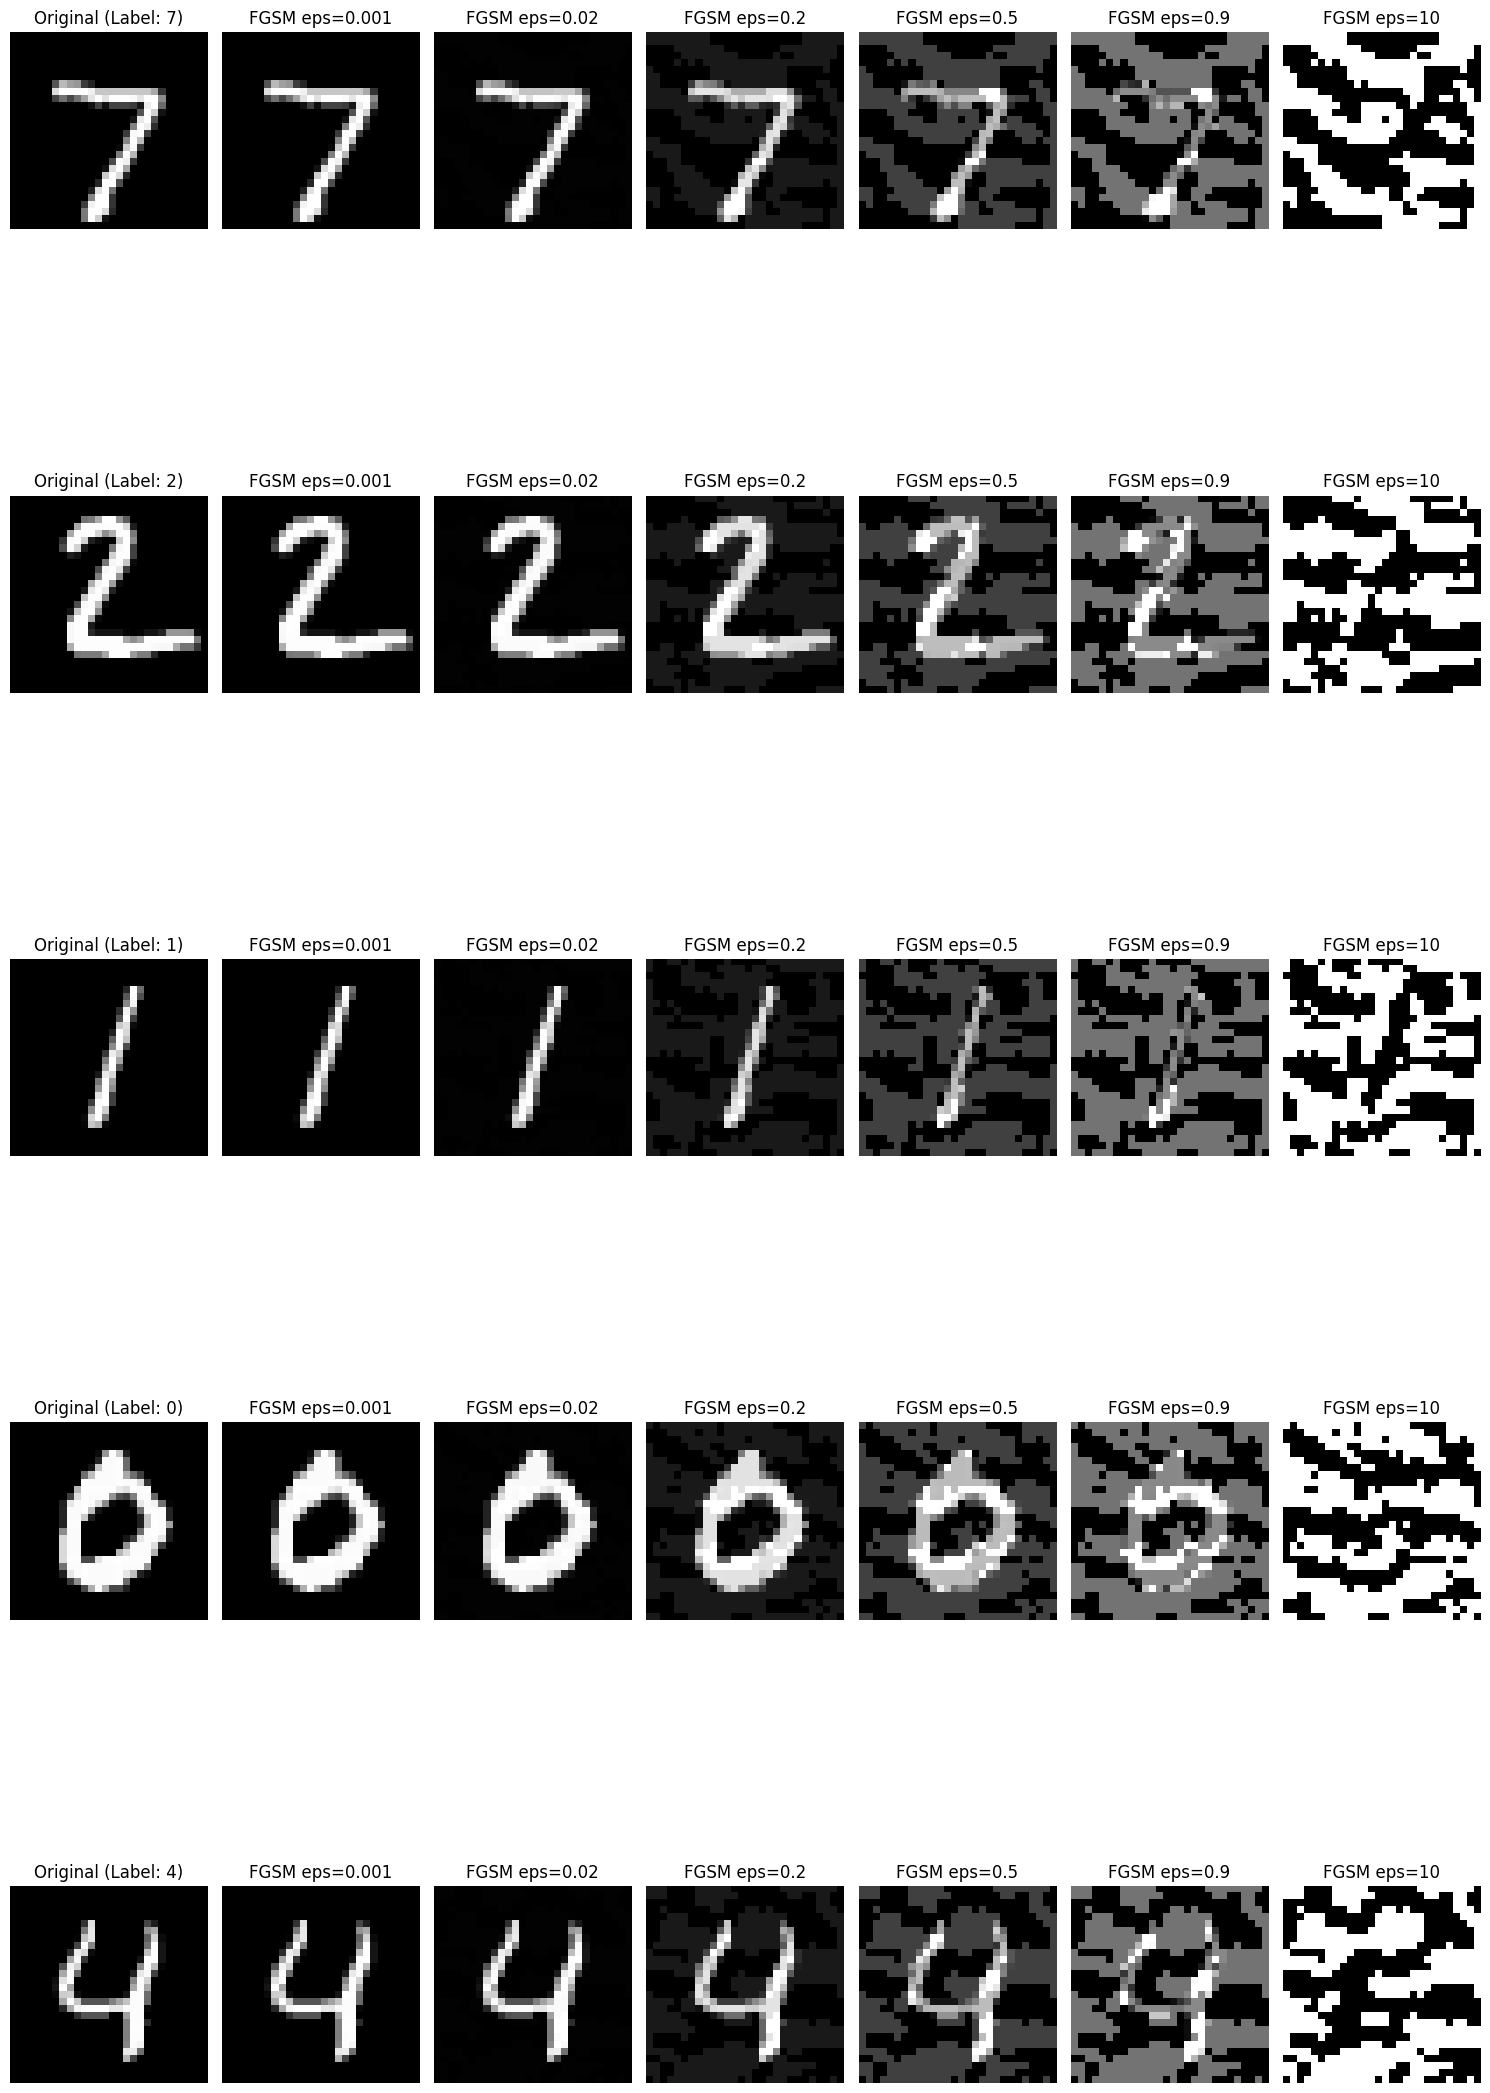

In [ ]:
import matplotlib.pyplot as plt

def display_attack_examples(model, test_loader, eps_values, device, clip_min, clip_max, num_images=5):
    model.eval() #Устанавливаем модель в режим оценки (eval()), чтобы отключить слои, такие как Dropout, которые активны только в режиме тренировки.
    images, labels = next(iter(test_loader)) #Берем первую партию изображений и меток из тестового загрузчика данных.
    images, labels = images[:num_images].to(device), labels[:num_images].to(device)

    fig, axes = plt.subplots(num_images, len(eps_values) + 1, figsize=(15, 5 * num_images)) #Создаем сетку графиков с количеством строк, равным количеству изображений (num_images)
    for i in range(num_images):
        # оригинальное изображение
        # Преобразуем тензор изображения в формат, совместимый с matplotlib (переносим на CPU, удаляем лишние измерения с помощью squeeze)
        # Используем метод imshow для визуализации, задаем заголовок с указанием метки (Label) и отключаем оси для более чистого отображения
        orig_img = images[i].detach().cpu().squeeze().numpy()  # отсоединить перед конвертацией в numpy
        axes[i, 0].imshow(orig_img, cmap='gray')
        axes[i, 0].set_title(f"Original (Label: {labels[i].item()})")
        axes[i, 0].axis('off')

        for j, eps in enumerate(eps_values): #Внешний цикл проходит по всем значениям eps, которые были переданы в функцию
            perturbed_images = images.clone().detach() # Клонируем оригинальные изображения и создаем копию, которая отсоединена от графа вычислений
            perturbed_images.requires_grad = True

            # Выполнить атаку FGSM
            outputs = model(perturbed_images)
            loss = torch.nn.functional.cross_entropy(outputs, labels)
            model.zero_grad()
            loss.backward()

            data_grad = perturbed_images.grad.data
            perturbed_images = perturbed_images + eps * data_grad.sign()
            perturbed_images = torch.clamp(perturbed_images, min=clip_min, max=clip_max)

            # Визуализация искаженных изображений
            perturbed_img = perturbed_images[i].detach().cpu().squeeze().numpy()  #
            axes[i, j + 1].imshow(perturbed_img, cmap='gray')
            axes[i, j + 1].set_title(f"FGSM eps={eps}")
            axes[i, j + 1].axis('off')

    plt.tight_layout()
    plt.show()

# Визуализация примеров атак для модели LeNet_MNIST на наборе данных MNIST
model = LeNet_MNIST().to(device)
model.load_state_dict(torch.load('weights/clean/mnist_lenet.pth', map_location=torch.device('cpu')))

eps_values = [0.001, 0.02, 0.2, 0.5, 0.9, 10]  # Определить значения эпсилон
display_attack_examples(model, mnist_loader_test, eps_values, device, mnist_min, mnist_max)


мы получаем графическое представление, показывающее оригинальные изображения из тестового набора MNIST и их искаженные версии после применения атаки FGSM с различными значениями параметра eps.

На выходе отображено:

* Сетка изображений: Для каждого оригинального изображения будет показан ряд с одним оригиналом и несколькими искаженными версиями, соответствующими различным значениям eps.

* Оригинальные изображения: В первой колонке каждого ряда будут оригинальные изображения с соответствующей меткой (Label).

* Искаженные изображения: В остальных колонках будут изображены версии оригинала, подвергшиеся атаке FGSM с заданными значениями eps (0.001, 0.02, 0.2, 0.5, 0.9 и 10). Каждый из этих искаженных вариантов будет заглавлен с указанием значения eps.

* Отсутствие осей: Оси на графиках будут отключены для более чистого отображения изображений.


**Измерение точности модели LeNet_MNIST на MNIST-датасете до и после атаки с различными значениями eps в рамках FGSM атаки. Результаты отображаются в виде таблицы, показывающей, насколько снизилась точность модели после применения атак.**

Функция оценивает точность модели как на чистых (без атак), так и на атакованных изображениях.На входе принимает модель, загрузчик данных (dataloader), устройство (device), минимальные и максимальные значения для ограничения значений пикселей (clip_min, clip_max), и значение eps.

In [ ]:
def evaluate_accuracy(model, dataloader, device, clip_min, clip_max, eps=None):
    model.eval()  # Устанавливаем модель в режим оценки
    correct = 0
    total = 0
    for images, labels in dataloader:  # Проходим по каждой партии данных из загрузчика
        images, labels = images.to(device), labels.to(device)  # Переносим данные на устройство (например, GPU)

        if eps is not None:
            # Атака FGSM
            images.requires_grad = True  # Включаем градиенты для изображений
            outputs = model(images)  # Прогоняем модель на изображениях
            loss = torch.nn.functional.cross_entropy(outputs, labels)  # Вычисляем функцию потерь
            model.zero_grad()  # Обнуляем градиенты модели
            loss.backward()  # Вычисляем градиенты по потерям
            data_grad = images.grad.data  # Получаем градиенты изображений

            # Создаем возмущенные изображения с использованием FGSM
            images = images + eps * data_grad.sign()  # Применяем FGSM, используя знак градиента и значение eps
            images = torch.clamp(images, clip_min, clip_max)  # Ограничиваем значения пикселей в пределах допустимого диапазона

        outputs = model(images)  # Прогоняем модель на (возможно, возмущенных) изображениях
        _, predicted = torch.max(outputs.data, 1)  # Определяем предсказанные классы
        total += labels.size(0)  # Увеличиваем общее количество изображений
        correct += (predicted == labels).sum().item()  # Подсчитываем количество правильных предсказаний

    return 100 * correct / total  # Возвращаем точность в процентах

# Оценка и сохранение результатов точности для различных значений epsilon
results = {"Model": [], "eps": [], "Accuracy Before Attack (%)": [], "Accuracy After Attack (%)": []}  # Словарь для хранения результатов
eps_values = [0.001, 0.02, 0.2, 0.5, 0.9, 10]  # Значения epsilon, используемые для FGSM атаки

# Для модели LeNet_MNIST на датасете MNIST
model = LeNet_MNIST().to(device)  # Создаем экземпляр модели и переносим на устройство
model.load_state_dict(torch.load('weights/clean/mnist_lenet.pth', map_location=torch.device('cpu')))  # Загружаем сохраненные веса модели

for eps in eps_values:  # Проходим по каждому значению epsilon
    acc_before = evaluate_accuracy(model, mnist_loader_test, device, mnist_min, mnist_max)  # Оцениваем точность до атаки (чистые изображения)
    acc_after = evaluate_accuracy(model, mnist_loader_test, device, mnist_min, mnist_max, eps=eps)  # Оцениваем точность после атаки

    # Сохраняем результаты
    results["Model"].append("LeNet_MNIST")
    results["eps"].append(eps)
    results["Accuracy Before Attack (%)"].append(acc_before)
    results["Accuracy After Attack (%)"].append(acc_after)

# Преобразуем результаты в DataFrame и выводим на экран
import pandas as pd
df_results = pd.DataFrame(results)
print(df_results)


         Model     eps  Accuracy Before Attack (%)  Accuracy After Attack (%)
0  LeNet_MNIST   0.001                       98.34                      98.31
1  LeNet_MNIST   0.020                       98.34                      97.44
2  LeNet_MNIST   0.200                       98.34                      63.33
3  LeNet_MNIST   0.500                       98.34                      17.12
4  LeNet_MNIST   0.900                       98.34                       6.19
5  LeNet_MNIST  10.000                       98.34                       5.86


* Model — название модели, используемой для оценки (в данном случае это LeNet_MNIST).
* eps — значения epsilon, используемые в методе атаки FGSM. Это параметр, который определяет силу атаки, т.е. насколько сильно изменяются пиксели изображений.
* Accuracy Before Attack (%) — процент точности модели на тестовом наборе до применения атаки FGSM. Это базовый показатель точности модели на чистых изображениях.
* Accuracy After Attack (%) — процент точности модели на тестовом наборе после применения атаки FGSM. Это показатель того, насколько модель устойчива к атакам для каждого значения eps.

**Вывод:**

В таблице представлены результаты тестирования модели LeNet_MNIST на наборе данных MNIST под воздействием FGSM-атаки (Fast Gradient Sign Method) с различными значениями параметра eps — интенсивности атаки. Вот ключевые выводы и интерпретация:

**Accuracy Before Attack (%)** — точность модели до атаки остаётся высокой и стабильной (98.34%) независимо от значения eps, что говорит о том, что модель изначально хорошо классифицирует чистые (неатакованные) изображения.

**Accuracy After Attack (%)** — точность модели после атаки снижается по мере увеличения значения eps. Это логично, так как с ростом eps возрастает и сила искажения, вносимого FGSM-атакой, что делает изображения более сложными для правильной классификации.

**Анализ влияния eps:**

* При очень малых значениях eps (0.001 и 0.02) точность модели практически не изменяется, что указывает на устойчивость модели к небольшим искажениям.
* При среднем значении eps (0.2) точность значительно падает (до 63.33%), что означает, что атака начинает серьезно нарушать работу модели.
* При высоких значениях eps (0.5 и выше) модель фактически не может справиться с классификацией, и точность падает до очень низких значений (около 6%).

**Заключение:** Данная таблица наглядно демонстрирует снижение устойчивости модели LeNet по мере увеличения силы FGSM-атаки. Это важный результат для понимания границ надежности модели и её способности противостоять определённым уровням атак.